#### Data fitting with continuity constraints

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')
np.set_printoptions(formatter={'float': '{: 0.1f}'.format})

(50,)
(50,)
(100,) (100,)


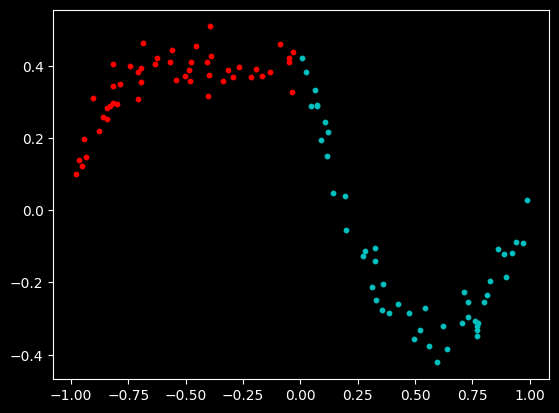

In [ ]:
np.random.seed(42)

n_data = 50
noise = 0.05
x_left, x_right = np.random.rand(n_data) - 1, np.random.rand(n_data)
print(x_left.shape)
print(x_right.shape)

def get_y(x, noise):
    return x ** 3 - x + 0.4 / (1 + (25 * (np.square(x)))) + noise * np.random.randn(x.shape[0])

y_left = get_y(x_left, noise)
y_right = get_y(x_right, noise)

x = np.concatenate((x_left, x_right))
y = np.concatenate((y_left, y_right))
print(x.shape, y.shape)

plt.scatter(x_left, y_left, s=10, color='r')
plt.scatter(x_right, y_right, s=10, color='c')
plt.show()

What we are trying to do is to fit two polynomials for the red dots and cyan dots separately, while having two fitted polynomials to have the same `function value` and `first derivative` when they meet

For example

$$\begin{align*}
p(x)&=\theta_1+\theta_2x+\theta_3x^2+\theta_4x^3, x\leq 0 \\
q(x)&=\theta_5+\theta_6x+\theta_7x^2+\theta_8x^3, x > 0
\end{align*}$$

and $p(0)=q(0), p'(0)=q'(0)$, or

$$\begin{align*}
\theta_1+\theta_2x+\theta_3x^2+\theta_4x^3 - \theta_5-\theta_6x-\theta_7x^2-\theta_8x^3 &=0 \\
\theta_2+2\theta_3x+3\theta_4x^2-\theta_6-2\theta_7x-3\theta_8x^2 &=0
\end{align*}$$

#### Formulate constrained least squares

We want to

$$\min \|A\theta-b\|^2, \text{s.t. } C\theta=d$$

where

$$\begin{align*}
A&=\begin{bmatrix}1 & x_1 & x_1^2 & x_1^3 & & & & \\ \vdots \\ 1 & x_n & x_n^2 & x_n^3 & & & & \\  & & & & 1 & x_{n+1} & x_{n+1}^2 & x_{n+1}^3 \\ & & & & \vdots \\ & & & & 1 & x_{2n} & x_{2n}^2 & x_{2n}^3
\end{bmatrix}, \, b=\begin{bmatrix}y_1 \\ \vdots \\ y_n  \\  y_{n+1}  \\ \vdots \\ y_{2n}
\end{bmatrix} \\
C &= \begin{bmatrix}1 & a & a^2 & a^3 & -1 & -a & -a^2 & -a^3 \\ 0 & 1 & 2a & 3a^2 & 0  & -1 & -2a & -3a^2 \end{bmatrix}, \, d=\begin{bmatrix}0\\0\end{bmatrix}
\end{align*}$$

$a$ is where we want the two polynomials to meet and we can set $a=0$

In [ ]:
x_l_vec = x_left.reshape(-1, 1)
x_l_block = np.hstack((np.ones((n_data, 1)), x_l_vec, x_l_vec ** 2, x_l_vec ** 3))
print(x_l_block.shape)

x_r_vec = x_right.reshape(-1, 1)
x_r_block = np.hstack((np.ones((n_data, 1)), x_r_vec, x_r_vec ** 2, x_r_vec ** 3))
print(x_r_block.shape)

A_top = np.hstack((x_l_block, np.zeros((n_data, 4))))
A_bottom = np.hstack((np.zeros((n_data, 4)), x_r_block))
A = np.vstack((A_top, A_bottom))
print(A.shape)

b = y.reshape(-1, 1)
print(b.shape)

C = np.hstack((np.eye(2), np.zeros((2,2)), -np.eye(2), np.zeros((2,2))))
print(C.shape)

d = np.zeros((2,1))
print(d.shape)

(50, 4)
(50, 4)
(100, 8)
(100, 1)
(2, 8)
(2, 1)


#### Solve KKT equation

$$\begin{bmatrix}A^TA & C^T \\ C & 0\end{bmatrix}\begin{bmatrix}\theta \\ \lambda\end{bmatrix}=\begin{bmatrix}A^Tb \\ d\end{bmatrix}$$

(10, 1)
(100, 1) (100, 1)


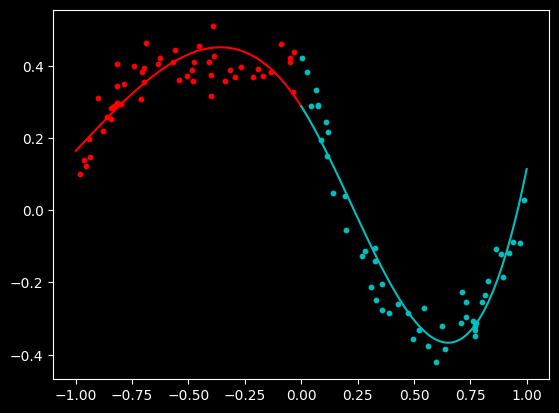

In [ ]:
kkt_mat = np.block([
        [A.T @ A , C.T],
        [C, np.zeros((C.shape[0], C.T.shape[1]))]
    ])

rhs = np.vstack([A.T @ b, d])
sol = np.linalg.inv(kkt_mat.T @ kkt_mat) @ kkt_mat.T @ rhs
print(sol.shape)

n_test = 100
x_t_left = np.linspace(-1, 0, n_test).reshape(-1,1)
x_t_right = np.linspace(0, 1, n_test).reshape(-1,1)

y_t_left = np.hstack((np.ones((n_test, 1)), x_t_left, x_t_left ** 2, x_t_left ** 3)) @ sol[:4]
y_t_right = np.hstack((np.ones((n_test, 1)), x_t_right, x_t_right ** 2, x_t_right ** 3)) @ sol[4:8]
print(y_t_left.shape, y_t_right.shape)

plt.scatter(x_left, y_left, s=10, color='r')
plt.scatter(x_right, y_right, s=10, color='c')
plt.plot(x_t_left, y_t_left, color='r')
plt.plot(x_t_right, y_t_right, color='c')
plt.show()